## 9.5.1 循环神经网络

上一节我们学习了语言模型的相关知识，大家应该不难理解，语言模型除了可以计算一个句子出现的概率，也可以用来预测给定文本情况下，下一个词到底是什么。此时可以就用N元语言模型的公式$P(x_t|x_{t-1},x_{t-2},\dots,x_{t-n+1})$来进行计算了。

此时，如果我们把$x_{t-1},x_{t-2},\dots,x_{t-n+1}$的序列信息用一个隐变量h来存储，那么公式$P(x_t|x_{t-1},x_{t-2},\dots,x_{t-n+1})$就可以近似等于$P(x_t|h_{t-1})$了。那么这个$h_{t-1}$要如何计算呢？

我们可以基于t-1时刻的输入x和它上一个时间步，t-2时刻的的隐状态$h_{t-2}$来计算$h_{t-1}$的值。此时可以得到隐状态计算公式：

$$h_t=f(x_t,h_{t-1})$$

这里面直接用了等于号，是因为理论上讲，隐变量$h_t$是可以存储到t时间步为止观测到的全部数据的。

上面这个公式对于你理解循环神经网络的结构非常重要。循环神经网络能够处理序列数据的秘密就在于此，它是一种具有隐状态的神经网络。下面我们来看看循环神经网络的网络结构。

## 9.5.2 网络结构

很多人在初学循环神经网络的时候，都会看到这样一张图，看着非常的简洁，但却不那么易懂。每个结点到底代表的是一个值的输入，还是说一层的向量结点集合，隐藏层又是如何连接到自己的呢？

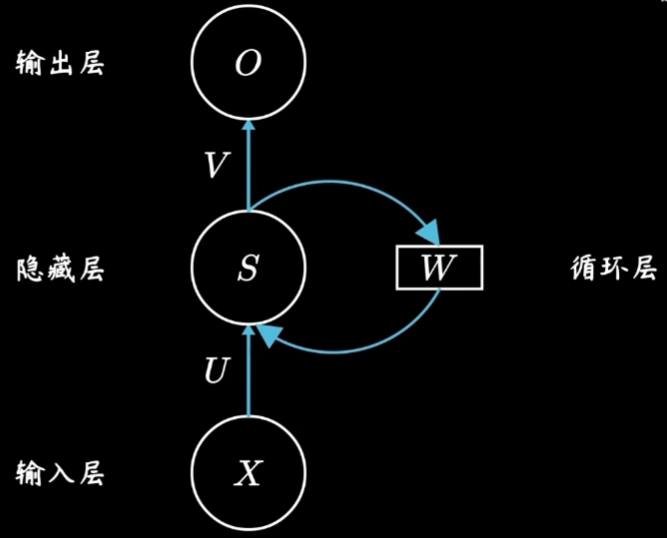

这张图确实比较抽象，我们不妨来看一下下面这张图。

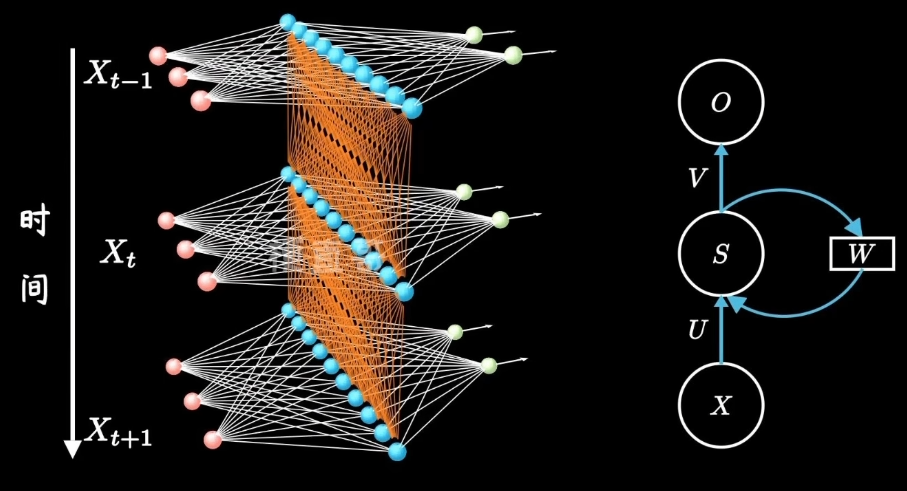

这里左侧的红色小球$x_{t-1},x_t,x_{t+1}$代表输入的序列数据，对应着右侧的X。中间的蓝色小球就是隐藏层，对应着右图的S。绿色的小球则是输出层，对应了右图的O。蓝色小球之间的连线，则正对应了右图S到W之间的连线。左侧横向的每一层网络，都可以看做一个完整的全连接神经网络，而正因为有了隐藏层之间的黄色的连线，它进化成了循环神经网络，模型由此具备了记忆能力。

RNN模型就是假定不同的层，也就是不同的时间步，共享同一个隐藏层权重矩阵W。 这样既可以让隐藏层包含过去的全部信息，也能够减少模型参数的数量。

前面我们讲过，在多层感知机中，隐藏层的数学表示为：

$$h = f(W_hh_{prev} + b_h)$$

其中，$h$ 是隐藏层的输出，$h_{prev}$ 是上一层（通常是输入层）的输出，$W_h$ 是隐藏层的权值矩阵，$b_h$ 是隐藏层的偏置向量，$f(\cdot)$ 是激活函数。

那么对于循环神经网络的隐藏层输出，则有如下的数学表示：
$$h = f(W_hh_{prev} + h_{t-1}W_{hh} + b_h)$$

$h_{t-1}$是前一个时间步的隐藏变量， $W_{hh}$是我们引入的一个新的权重参数。多出来的这一项$h_{t-1}W_{hh}$体现了在当前时间步中使用前一个时间步的隐藏变量。当然这只是循环神经网络的一种常见形式。

接下来我们来看一下循环神经网络的代码实现。

## 9.5.3 代码实现

首先我们引入第2节中讲到的词表的代码。

In [1]:
import collections

class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

加载好了词表类后，我们就开始建立RNN模型。

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import string
from zhon.hanzi import punctuation
import random

# 读取文件，去除标点等无关信息
with open('data/越女剑.txt', 'r') as f:
    lines = f.readlines()
exclude = set(punctuation)
tokens = [ ''.join(ch for ch in line if ch not in exclude).replace('\n','') for line in lines]
tokens = [token for line in tokens for token in line]


# 生成词表
vocab = Vocab(tokens)
corpus = [vocab[token] for line in tokens for token in line]

batch_size = 32
num_steps = 35

# 生成数据迭代器

def corpus_data_iterator(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class DataLoader:
    def __init__(self):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_steps = num_steps
    
    def __iter__(self):
        return corpus_data_iterator(self.corpus, self.batch_size, self.num_steps)

train_iter = DataLoader()

num_hiddens = 512
rnn_layer = nn.RNN(len(vocab), num_hiddens)

state = torch.zeros((1, batch_size, num_hiddens))
state.shape

X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens))
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens)),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens)))

net = RNNModel(rnn_layer, vocab_size=len(vocab))

模型代码写好了，我们先来预测一下看看。

In [3]:
prefix = '越女'
num_preds = 10

def predict(prefix, num_preds, net, vocab):
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]]).reshape(1,1)

    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

print(predict(prefix, num_preds, net, vocab))

越女颇殷情情情朵为朵堪赴


由于我们没有进行模型训练，现在生成的内容基本上没有任何意义。

接下来我们做一下训练。

In [4]:
num_epochs, lr = 100, 1

criterion = nn.CrossEntropyLoss()
trainer = torch.optim.Adam(net.parameters(), lr)

def grad_clipping(net, theta):
    """Clip the gradient.

    Defined in :numref:`sec_rnn_scratch`"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

loss_history = []
state = net.begin_state(batch_size=X.shape[0])

for epoch in range(num_epochs):
    for X, Y in train_iter:
        y = Y.T.reshape(-1)
        y_hat, state = net(X, state)
        l = criterion(y_hat, y.long()).mean()
        trainer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        trainer.step()
    net.eval()
    if epoch % 10 == 0:
        with torch.no_grad():
            total_loss = 0
            t = 0
            for X, y in train_iter:
                y = Y.T.reshape(-1)
                y_hat, state = net(X, state)
                l = criterion(y_hat, y.long()).mean()
                total_loss += l.sum()/l.numel()
                t = t+1
            avg_loss = total_loss / t
            loss_history.append(avg_loss)
        print(f'Epoch {epoch+1}: Validation loss = {avg_loss:.4f}')
        print(predict(prefix, num_preds, net, vocab))

越女其说国山国山国山国山
越女士剑蠡士搭几蠡于几挤
越女的国亦兄士娃已固吟娃
越女剑口不将身青山范到准
越女头一法去的去的侮的侮
越女剑法们一烛听烛止烛止
越女去便利国觉风觉芍觉芍
越女得着范打王羊首打首打
越女的伍从剑在剑有瘦有瘦
越女剑贯被着被好被贯被贯
越女的他不手这手邦手邦手
越女的咽域怎域消域兵域兵
越女划奋个奋剑来范来范来
越女寡格之薛破晓破晓破晓
越女他首术剑术剑术剑术剑
越女剑了求泪卉王求脸求脸
越女事可事的事人事人事人
越女的惊仔左仔请仔请仔请
越女别初想呵事呵字初字初
越女国一去道去断外断外断
越女念士践已只已玩已玩已
越女这容不为够身尺身尺身
越女剑子嗯子掠子苦子苦子
越女歌声日住日住日住日住
越女是灰躬她好她身她身她
越女这名蠡率蠡率欧率欧率
越女是一的大暖布见酱见酱
越女的骇般骇般骇显骇显骇
越女人躬是两蠡两蠡两蠡两
越女剑名一饭一第一饭一饭
越女的掠乡奔败成败务败务
越女道手咽送船物他物他物
越女剑山勾蠡笑蠡笑采笑采
越女施手施手以如施如施如
越女着受蠡臂未终往终往终
越女的哈鱼剑鱼半鱼半鱼半
越女的比余做队这颤这颤这
越女一是声食夷咯夷食夷食
越女睛也的也范也范也范也
越女真胸点蓦点乃从乃从乃
越女我的家也家急家急家急
越女道像事子衫子三子三子
越女只么宛蠡他蠡对蠡对蠡
越女陰蠡道自国锐施锐施锐
越女在头在是范中羊中羊中
越女哪大父大父大名大名大
越女大迅内楚名楚名楚名楚
越女民还真范余他庞他庞他
越女岂是的火美剑我剑我剑
越女剑侮然心吴侮灵侮灵侮
